In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

编码器

---

嵌入层（Embedding Layer）：用于将输入的词元（单词、字符等）转换为特征向量，这些特征向量捕捉了词元的语义信息。

门控循环单元（GRU）：一种改进的 RNN 单元，解决了传统 RNN 中的梯度消失问题，更适合处理长序列。

In [2]:
'''
vocab_size：词表大小，即可以处理的不同词元的数量。
embed_size：每个词元的特征向量的维度。
num_hiddens：隐藏层的神经元数量，即隐状态的维度。
num_layers：GRU 的层数。


`super(Seq2SeqEncoder, self).__init__(**kwargs)` 
这一行代码的作用和具体意思可以通过以下几点来解释：

1. 继承
`Seq2SeqEncoder` 继承自 `d2l.Encoder`，所以它是 `d2l.Encoder` 的一个子类。
继承意味着 `Seq2SeqEncoder` 会继承 `d2l.Encoder` 类中的所有方法和属性。

2. 调用父类的构造函数
`super(Seq2SeqEncoder, self)` 是 Python 中调用父类（即基类）的方法。
这里的 `super` 函数返回当前类 `Seq2SeqEncoder` 的父类 `d2l.Encoder`。

3. 初始化父类
`super(Seq2SeqEncoder, self).__init__(**kwargs)` 调用了父类 `d2l.Encoder`
的构造函数 `__init__` 方法，并将关键字参数 `**kwargs` 传递给它。
这样可以确保 `d2l.Encoder` 的初始化逻辑被执行。

4. 参数传递
`**kwargs` 表示任意数量的关键字参数。这意味着你可以向 `Seq2SeqEncoder` 
传递一些参数，这些参数会被传递给 `d2l.Encoder` 的构造函数。

在初始化方法中：

self.embedding 是一个嵌入层，它把词元的索引映射到特征向量。
self.rnn 是一个多层 GRU，用于处理序列数据。

'''

class Seq2SeqEncoder(d2l.Encoder):
    #用于序列到序列学习的循环神经网络编码器
    def __init__(
    self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs
    ):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size, num_hiddens, num_layers, dropout=dropout
        )
    '''
    X 是输入，形状为 (batch_size, num_steps)，其中 batch_size 是批量大小，
    num_steps 是序列长度。
    
    self.embedding(X) 将输入的词元索引转换为特征向量，
    形状变为 (batch_size, num_steps, embed_size)。
    
    X.permute(1, 0, 2) 将维度顺序调整为
    (num_steps, batch_size, embed_size)，因为 GRU 需要第一个维度是时间步。
    
    self.rnn(X) 运行 GRU，得到 output 和 state：
        output 是每个时间步的输出，形状为 
        (num_steps, batch_size, num_hiddens)。
        
        state 是每层最后一个时间步的隐状态，形状为 
        (num_layers, batch_size, num_hiddens)。
        
    '''
    def forward(self, X, *args):
        # 输入‘X’的形状：（batch_size, num_steps, embed_size）
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状：(num_steps, batch_size, num_hiddens)
        # state的形状：(num_layers, batch_size, num_hiddens)
        return output, state
    
    '''
    总结
        嵌入层：将输入序列中的词元索引转换为特征向量。
        GRU：处理特征向量序列，生成每个时间步的输出和最终的隐状态。
        前向传播：将输入通过嵌入层，再通过 GRU，得到输出和隐状态。
        这个编码器的设计允许它处理可变长度的输入序列，并将序列信息编码到一个固定形状的隐状态中，从而为解码器生成输出序列提供信息。
    '''

In [3]:
'''
vocab_size=10：词汇表大小是10，表示可以有10种不同的词。
embed_size=8：每个词被嵌入到一个8维的向量中。
num_hiddens=16：每个隐藏层有16个隐藏单元。
num_layers=2：编码器由2层GRU组成。

实例化编码器
'''
encoder = Seq2SeqEncoder(
    vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2
)
# 设置编码器为评估模式
encoder.eval()

Seq2SeqEncoder(
  (embedding): Embedding(10, 8)
  (rnn): GRU(8, 16, num_layers=2)
)

In [4]:
# 定义输入序列
X = torch.zeros((4,7), dtype=torch.long)
# 通过编码器处理输入
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [5]:
'''
output.shape: torch.Size([7, 4, 16])

时间步数（7）：这个维度表示序列的时间步数。这里是7，表示每个输入序列有7个时间步。

批量大小（4）：这个维度表示批量大小。这里是4，表示我们一次处理4个序列。

隐藏单元数（16）：这个维度表示每个时间步的隐藏单元数。
这里是16，表示GRU的隐藏状态有16个单元。

7个时间步、4个序列、每个序列在每个时间步都有16维的隐藏状态，所以形状是 [7, 4, 16]。

'''
print("output.shape:",output.shape)

'''
state.shape: torch.Size([2, 4, 16])

隐藏层数量（2）：这个维度表示隐藏层的数量。这里是2，表示编码器有2层GRU。

批量大小（4）：这个维度表示批量大小。这里是4，表示我们一次处理4个序列。

隐藏单元数（16）：这个维度表示每个隐藏层的隐藏单元数。
这里是16，表示每个GRU层的隐藏状态有16个单元。

2层GRU、4个序列、每层的隐藏状态有16维，所以形状是 [2, 4, 16]。

'''
print("state.shape:",state.shape)

output.shape: torch.Size([7, 4, 16])
state.shape: torch.Size([2, 4, 16])


----

解码器

In [6]:
'''
解码器的工作原理

在序列到序列模型中，解码器的输入是编码器的输出（隐状态）和上一步解码器的输出。
为了确保解码器能访问整个输入序列的编码信息，
我们将编码器的最后一层的隐状态重复并拼接到解码器的每一个时间步的输入中。

在序列到序列（Seq2Seq）模型中，解码器的任务是根据编码器生成的隐状态和上下文向量逐步生成输出序列。
每个时间步的输出不仅依赖于当前的输入，还依赖于之前的输出和隐状态。



vocab_size：词汇表大小。

embed_size：嵌入层的维度。

num_hiddens：GRU隐藏单元的数量。

num_layers：GRU层数。

dropout：dropout概率。

self.embedding：将词元索引映射到特征向量的嵌入层。

self.rnn：多层GRU，输入是特征向量和隐状态。

self.dense：全连接层，将GRU的输出转换为词元的概率分布。

'''

class Seq2SeqDecoder(d2l.Decoder):
    # 用于序列到序列学习的循环神经网络解码器
    def __init__(
        self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs
    ):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens,
            num_hiddens,
            num_layers,
            dropout=dropout
        )
        self.dense = nn.Linear(num_hiddens, vocab_size)
    '''
    初始化解码器状态 init_state
    
    enc_outputs：编码器的输出。
    返回编码器的隐状态，作为解码器的初始隐状态。
    '''
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    '''
        
        
    '''
    def forward(self, X, state):
        # 输出‘X’的形状：（batch_size, num_steps, embed_size）
        '''
        1. 嵌入层转换
            - `X`：输入序列。
            - `self.embedding(X)`：将词元索引转换为特征向量，
                形状为 `(batch_size, num_steps, embed_size)`。
            - `permute(1, 0, 2)`：调整维度顺序为 `(num_steps, batch_size, embed_size)`。
            
        X.shape: torch.Size([4, 7])
        self.embedding(X).shape: torch.Size([4, 7, 8])
        self.embedding(X).permute(1, 0, 2).shape: torch.Size([7, 4, 8])
        '''
        X = self.embedding(X).permute(1, 0, 2)
        
        '''
        2. 上下文向量
            - `state[-1].repeat(X.shape[0], 1, 1)`：将上下文向量复制以匹配输入序列的时间步数，
            形状为 `(num_steps, batch_size, num_hiddens)`。

            `state[-1]`
                - `state` 是编码器的隐状态，形状为 `[num_layers, batch_size, num_hiddens]`。
                - `state[-1]` 选择的是编码器的最后一层的隐状态，形状为 `[batch_size, num_hiddens]`。
            假设 `state` 的形状是 `[2, 4, 16]`，那么 `state[-1]` 的形状是 `[4, 16]`。
        

        `repeat(X.shape[0], 1, 1)`
            - `repeat` 用于沿指定的维度重复张量。
            - `state[-1].repeat(X.shape[0], 1, 1)` 表示将 `state[-1]` 沿第一个维度重复 `X.shape[0]` 次。
        假设 `state[-1]` 的形状是 `[4, 16]`，且 `X.shape[0]` 是 `7`，那么 `state[-1].repeat(7, 1, 1)` 的形状是 `[7, 4, 16]`。

        
        X.shape: torch.Size([7, 4, 8])
        
        state.shape: torch.Size([2, 4, 16])
        state[-1].shape: torch.Size([4, 16])
        
        context.shape: torch.Size([7, 4, 16])
        '''
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        
        
        '''
        3. 拼接输入和上下文：
            - `torch.cat((X, context), 2)`：在最后一个维度拼接特征向量和上下文向量，
            形状为 `(num_steps, batch_size, embed_size + num_hiddens)`。
        
        X_and_context.shape: torch.Size([7, 4, 24])
        '''
        X_and_context = torch.cat((X, context), 2)
        
        
        
        '''
        4. 通过GRU
            - `self.rnn(X_and_context, state)`：计算GRU的输出和新隐状态。
            - `output`：形状为 `(num_steps, batch_size, num_hiddens)`。
            - `state`：形状为 `(num_layers, batch_size, num_hiddens)`。

        output.shape torch.Size([7, 4, 16])
        state.shape torch.Size([2, 4, 16])
        
        '''
        
        output, state = self.rnn(X_and_context, state)
        
        '''
        5. 输出层
            - `self.dense(output)`：将GRU的输出转换为词元的概率分布。
            - `permute(1, 0, 2)`：调整维度顺序为 `(batch_size, num_steps, vocab_size)`。

        output.shape torch.Size([4, 7, 10])
        '''
        output = self.dense(output).permute(1, 0, 2)
        
        # output的形状：(batch_size, num_steps, vocab_size)
        # state的形状：(num_layers, batch_size, num_hiddens)
        return output, state

In [7]:
decoder = Seq2SeqDecoder(
    vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2
)

decoder.eval()

Seq2SeqDecoder(
  (embedding): Embedding(10, 8)
  (rnn): GRU(24, 16, num_layers=2)
  (dense): Linear(in_features=16, out_features=10, bias=True)
)

In [8]:
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

损失函数

In [9]:
'''
在序列到序列（seq2seq）模型中，我们经常需要对不同长度的序列进行批量处理。
为了使这些序列具有相同的形状，我们会在短序列的末尾填充特殊的填充词元。
训练过程中，我们不希望填充词元影响损失的计算，因此需要屏蔽这些不相关的填充词元。
sequence_mask 函数就是用来实现这个目的的。


参数解释

- `X`：输入张量，形状为 `[batch_size, maxlen]`，其中 `maxlen` 是序列的最大长度。
- `valid_len`：每个序列的有效长度，即不包括填充词元的实际长度。形状为 `[batch_size]`。
- `value`：要用来屏蔽不相关项的值，默认为 `0`。

'''
def sequence_mask(X, valid_len, value=0):
    # 在序列中屏蔽不相关的项
    '''
    X.shape: torch.Size([2, 3])
    valid_len.shape: torch.Size([2])
    

    1. 获取最大长度

       ```python
       maxlen = X.size(1)
       ```

       获取输入张量 `X` 的第二维度（时间步长度）的大小，即最大长度 `maxlen`。
    '''
    maxlen = X.size(1)
    '''
    maxlen: 3

    '''
    mask = torch.arange(
        (maxlen),
        dtype=torch.float32,
        device=X.device
    )[None, :] < valid_len[:, None]
    
    '''
    mask: tensor([[ True, False, False],
        [ True,  True, False]])
    X: tensor([[1, 2, 3],
            [4, 5, 6]])
    
    torch.arange((maxlen),dtype=torch.float32,device=X.device)[None, :].shape: torch.Size([1, 3])
    torch.arange((maxlen),dtype=torch.float32,device=X.device)[None, :]: tensor([[0., 1., 2.]])
    
    valid_len[:, None].shape: torch.Size([2, 1])
    valid_len[:, None]: tensor([[1],
        [2]])
    
    mask.shape: torch.Size([2, 3])
    
    2. **创建掩码**

       ```python
       mask = torch.arange((maxlen), dtype=torch.float32,
                           device=X.device)[None, :] < valid_len[:, None]
       ```

       - `torch.arange((maxlen), dtype=torch.float32, device=X.device)` 创建一个从 `0` 到 `maxlen-1` 的一维张量。
       - `[None, :]` 增加一个维度，使其形状变为 `[1, maxlen]`。
       - `valid_len[:, None]` 将 `valid_len` 的形状从 `[batch_size]` 变为 `[batch_size, 1]`。
       - 比较操作 `<` 会广播，使得 `mask` 的形状变为 `[batch_size, maxlen]`，其中每个元素表示该位置是否在有效长度内。
    '''
    X[~mask] = value
    '''
    X: tensor([[1, 0, 0],
            [4, 5, 0]])
            
    3. **应用掩码**

       ```python
       X[~mask] = value
       ```

       - `~mask` 是 `mask` 的按位取反，表示填充部分。
       - `X[~mask] = value` 将 `X` 中不在有效长度内的部分设置为 `value`（默认是 `0`）。

    '''
    return X

In [10]:
X = torch.tensor(
    [
        [1, 2, 3],
        [4, 5, 6]
    ]
)
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [11]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [12]:
'''
自定义的带遮蔽的Softmax交叉熵损失函数 `MaskedSoftmaxCELoss` 以及示例代码。

`MaskedSoftmaxCELoss` 类

这个类继承了 `torch.nn.CrossEntropyLoss`，并重写了 `forward` 方法以实现带遮蔽的损失计算。

'''

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # 带遮蔽的softmax交叉熵损失函数
    # pred的形状：（batch_size, num_steps, vocab_size）
    # label的形状：(batch_size, num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        '''
        1. 创建权重张量

           ```python
           weights = torch.ones_like(label)
           ```

           创建一个与 `label` 形状相同的全1张量，作为初始的权重张量。
        
         weights: tensor([[1, 1, 1, 1],
                [1, 1, 1, 1],
                [1, 1, 1, 1]])
        '''
        weights = torch.ones_like(label)
        '''
        2. 应用序列掩码

           ```python
           weights = sequence_mask(weights, valid_len)
           ```

           使用 `sequence_mask` 函数将权重张量中无效长度（填充部分）的位置设置为0。
           
        weights: tensor([[1, 1, 1, 1],
            [1, 1, 0, 0],
            [0, 0, 0, 0]])

        '''
        weights = sequence_mask(weights, valid_len)
        '''
        3. 设置不进行自动归约

           ```python
           self.reduction = 'none'
           ```

           将损失函数的归约方式设置为 `none`，以便获取逐元素的损失值，而不是直接求和或平均。
        '''
        self.reduction='none'
        '''
        
        4. 计算未加权的交叉熵损失

           ```python
           unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
               pred.permute(0, 2, 1), label)
           ```
           
           super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label) 的作用是
           调用 nn.CrossEntropyLoss 类的 forward 方法。

           - `pred.permute(0, 2, 1)`：将预测张量的形状从 
           `(batch_size, num_steps, vocab_size)` 变为 
           `(batch_size, vocab_size, num_steps)`，
           以匹配 `nn.CrossEntropyLoss` 的输入要求。
           - 计算未加权的交叉熵损失。
           
        unweighted_loss: tensor([[2.3026, 2.3026, 2.3026, 2.3026],
                [2.3026, 2.3026, 2.3026, 2.3026],
                [2.3026, 2.3026, 2.3026, 2.3026]])

        '''
        unweighted_loss = super(
            MaskedSoftmaxCELoss, self
        ).forward(
            pred.permute(0, 2, 1),
            label
        )
        '''
           
        5. 加权损失并计算平均值

           ```python
           weighted_loss = (unweighted_loss * weights).mean(dim=1)
           ```

           - 将未加权的损失 `unweighted_loss` 与权重张量 `weights` 元素相乘，
           屏蔽掉无效部分的损失。
           - 对每个样本的时间步维度（`num_steps`）求平均，得到每个样本的加权损失。
        '''
        weighted_loss = (
            unweighted_loss * weights
        ).mean(dim=1)
        return weighted_loss

In [13]:
loss = MaskedSoftmaxCELoss()
loss(
    torch.ones(3, 4, 10),
    torch.ones(
        (3, 4), dtype=torch.long
    ),
    torch.tensor([4, 2, 0])
)

tensor([2.3026, 1.1513, 0.0000])

#### 示例代码

```python
loss = MaskedSoftmaxCELoss()
result = loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))
print(result)
```

假设 `torch.ones(3, 4, 10)` 是预测张量 `pred`，`torch.ones((3, 4), dtype=torch.long)` 是标签张量 `label`，`torch.tensor([4, 2, 0])` 是有效长度 `valid_len`。

1. **输入张量**

   - `pred`：形状为 `(3, 4, 10)` 的全1张量，表示批量大小为3，每个序列长度为4，每个词元的词汇表大小为10。
   - `label`：形状为 `(3, 4)` 的全1张量，表示每个词元的标签索引为1。
   - `valid_len`：形状为 `(3,)`，值为 `[4, 2, 0]`，表示三个序列的有效长度分别为4、2和0。

2. **权重张量**

   ```python
   weights = sequence_mask(weights, valid_len)
   ```

   - `weights` 初始为全1张量，形状为 `[3, 4]`。
   - 应用 `sequence_mask` 后，`weights` 变为：

     ```
     tensor([[1, 1, 1, 1],
             [1, 1, 0, 0],
             [0, 0, 0, 0]])
     ```

3. **未加权的交叉熵损失**

   假设未加权的交叉熵损失 `unweighted_loss` 计算后是形状为 `[3, 4]` 的张量。由于 `pred` 和 `label` 都是全1张量，预测和标签完全一致，损失为某个常数值（例如 `2.3026`，对应 `-log(1/10)`）。

   ```
   unweighted_loss:
   tensor([[2.3026, 2.3026, 2.3026, 2.3026],
           [2.3026, 2.3026, 2.3026, 2.3026],
           [2.3026, 2.3026, 2.3026, 2.3026]])
   ```

4. **加权损失**

   ```python
   weighted_loss = (unweighted_loss * weights).mean(dim=1)
   ```

   - 加权后的损失：

     ```
     tensor([[2.3026, 2.3026, 2.3026, 2.3026],
             [2.3026, 2.3026, 0.0000, 0.0000],
             [0.0000, 0.0000, 0.0000, 0.0000]])
     ```

   - 按时间步维度求平均：

     ```
     tensor([2.3026, 1.1513, 0.0000])
     ```

5. **结果**

   最终结果为每个序列的加权损失：

   ```python
   tensor([2.3026, 1.1513, 0.0000])
   ```

   解释：
   - 第一个序列的有效长度为4，所有时间步的损失都有效，平均损失为 `2.3026`。
   - 第二个序列的有效长度为2，只有前两个时间步的损失有效，平均损失为 `1.1513`（即 `2.3026 / 2`）。
   - 第三个序列的有效长度为0，所有时间步的损失都无效，平均损失为 `0.0000`。

### 总结

- `MaskedSoftmaxCELoss` 类通过继承 `nn.CrossEntropyLoss` 并重写 `forward` 方法，实现了对填充词元的遮蔽。
- 使用 `sequence_mask` 函数生成遮蔽掩码，避免填充词元对损失计算的干扰。
- 通过示例代码展示了带遮蔽损失计算的具体过程，验证了不同有效长度下损失的计算结果。

训练

---

强制教学（teacher forcing）是一种训练序列到序列模型的方法。在这种方法中，解码器在训练时每一步的输入都是由真实的目标序列提供，而不是由解码器前一步的预测提供。让我们详细解释这个概念。

### 强制教学的目的

在训练序列到序列模型（例如机器翻译模型）时，解码器需要在每个时间步生成下一个词元。在训练期间，如果每一步都使用解码器前一步的预测作为输入，错误可能会不断累积，导致模型难以学习正确的序列生成方式。为了解决这个问题，可以使用强制教学。

### 强制教学的过程

1. **输入序列**：假设我们的输入序列是 `X`。
2. **目标序列**：目标序列是我们希望模型生成的正确输出 `Y`。
3. **初始化解码器**：解码器的输入序列以特殊的开始标记 `<bos>`（beginning of sequence）开始。
4. **每一步输入**：
   - 在训练过程中，解码器的每一步输入由目标序列提供，而不是使用解码器上一步的输出。这意味着在解码器的第一个时间步，输入是 `<bos>`，在第二个时间步，输入是目标序列的第一个词元，以此类推。
   
### 代码中的强制教学

在代码中，我们看到以下部分：

```python
bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
```

1. **创建 `<bos>` 标记**：
   ```python
   bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
   ```
   这行代码创建了一个张量 `bos`，其中包含批量大小个 `<bos>` 标记，每个标记作为解码器输入序列的第一个词元。

2. **拼接输入序列**：
   ```python
   dec_input = torch.cat([bos, Y[:, :-1]], 1)
   ```
   这里将 `<bos>` 标记和目标序列 `Y` 的前 `n-1` 个词元拼接起来，形成解码器的输入序列 `dec_input`。这样，解码器的输入序列就变成了 `[<bos>, Y[0], Y[1], ..., Y[n-2]]`，这就是强制教学的实现方式。

### 强制教学的优势

1. **减少错误传播**：使用真实的目标序列作为输入，减少了模型由于自身错误预测而导致的误差累积。
2. **更快收敛**：模型可以更快地学会正确的序列生成，因为它总是看到正确的输入和输出对。

### 总结

强制教学是通过使用目标序列中的真实词元作为解码器每一步的输入来训练序列到序列模型的方法。这可以帮助模型更快地学习并减少训练期间的错误传播。

In [14]:
def train_seq2seq(
    net, data_iter, lr, num_epochs, tgt_vocab, device
):
    
    '''
    训练序列到序列模型
    
    初始化和准备工作
    
    1. 权重初始化函数
    ```python
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    ```
    - 这个函数用于初始化模型中的线性层和GRU层的权重。
    - `nn.init.xavier_uniform_` 是一种常用的初始化方法，使得网络更容易训练。

    '''
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(
                        m._parameters[param]
                    )
                    
    '''
     
    2. 应用权重初始化并将模型移至设备（GPU或CPU）
        ```python
        net.apply(xavier_init_weights)
        net.to(device)
        ```
        - `net.apply` 将初始化函数应用到模型的所有子模块上。
        - `net.to(device)` 将模型移动到指定设备（例如GPU）上，以加速训练。

    '''
    net.apply(xavier_init_weights)
    net.to(device)
    
    '''
    3. 设置优化器和损失函数
        ```python
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        loss = MaskedSoftmaxCELoss()
        ```
        - 使用Adam优化器进行梯度下降。
        - 使用之前定义的带遮蔽的softmax交叉熵损失函数。

    '''
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=lr
    )
    loss = MaskedSoftmaxCELoss()
    '''
    4. 设置动画器
        ```python
        animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
        ```
        - 用于可视化训练过程中的损失变化。

    '''
    # 进入训练模式
    net.train()
    animator = d2l.Animator(
        xlabel='epoch',
        ylabel='loss',
        xlim=[10, num_epochs]
    )
    
    # 训练循环
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        # 训练损失总和，词元数量
        metric = d2l.Accumulator(2) 

        for batch in data_iter:
            optimizer.zero_grad() # 清除梯度。
            # 从批量数据中获取输入和输出序列及其有效长度。
            X, X_valid_len, Y, Y_valid_len = [
                x.to(device) for x in batch
            ]
            '''
            创建一个序列开始词元`<bos>`
            
            1. `tgt_vocab['<bos>']`
            首先，`tgt_vocab['<bos>']` 是获取
            目标词汇表（target vocabulary）中 `<bos>` 标记对应的索引。
            假设 `<bos>` 在词汇表中的索引是 1，那么 `tgt_vocab['<bos>']` 就是 1。
            
            2. `[tgt_vocab['<bos>']] * Y.shape[0]`

            假设 `Y.shape[0]` 是批量大小（batch size）。
            例如，批量大小为 4，那么 `Y.shape[0]` 就是 4。
            `[tgt_vocab['<bos>']] * Y.shape[0]` 
            会生成一个包含 4 个 `<bos>` 索引的列表。比如，`[1, 1, 1, 1]`。
            
            3. `.reshape(-1, 1)`

            最后，`.reshape(-1, 1)` 会把张量的形状从 `[4]` 转换为 `[4, 1]`，
            即每个 `<bos>` 索引变成一个单独的行：

            ```python
            tensor([[1],
                    [1],
                    [1],
                    [1]], device='cuda:0')
            ```

            '''
            bos = torch.tensor(
                [tgt_vocab['<bos>']] * Y.shape[0],
                device=device
            ).reshape(-1, 1)
            '''
            将`<bos>`和原始输出序列拼接作为解码器的输入，
            这被称为“强制教学”。
            '''
            dec_input = torch.cat(
                [bos, Y[:, :-1]], 1
            )
            # 获取模型的预测输出
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            # 损失函数的标量进行‘反向传播’
            l.sum().backward()
            # 裁剪梯度以防止梯度爆炸
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 累加损失和词元数量
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(
                epoch + 1,
                (metric[0] / metric[1],)
            )
            
    print(
        f'loss {metric[0] / metric[1]:.3f}, ', 
        f'{metric[1] / timer.stop():.1f}, ',
        f'tokens/sec on {str(device)}'
    )    

In [15]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64,10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

loss 0.019,  2747.7,  tokens/sec on cpu


'\n总结\n\n- **编码器**：\n将输入序列编码成隐状态。\n\n- **解码器**：\n使用编码器的隐状态和强制教学进行序列生成。\n\n- **训练循环**：\n通过梯度下降优化模型参数，使用带遮蔽的交叉熵损失函数来计算损失。\n\n- **强制教学**：\n在解码过程中使用真实的目标序列来指导模型的学习。\n'

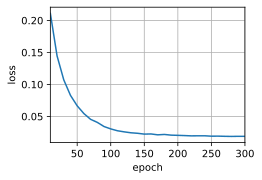

In [16]:
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab),
    embed_size,
    num_hiddens,
    num_layers,
    dropout
)
decoder = Seq2SeqDecoder(
    len(tgt_vocab),
    embed_size,
    num_hiddens,
    num_layers,
    dropout
)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

'''
总结

- **编码器**：
将输入序列编码成隐状态。

- **解码器**：
使用编码器的隐状态和强制教学进行序列生成。

- **训练循环**：
通过梯度下降优化模型参数，使用带遮蔽的交叉熵损失函数来计算损失。

- **强制教学**：
在解码过程中使用真实的目标序列来指导模型的学习。
'''

预测

In [17]:
def predict_seq2seq(
    net, 
    src_sentence, 
    sec_vocab, 
    tgt_vocab, 
    num_steps, 
    device, 
    save_attention_weights=False
):
    '''
    序列到序列模型的预测
    在预测时将net设置为评估模式
    这会禁用dropout层和其他仅在训练时使用的层。
    
    
    准备输入序列

    1. Token化和转为小写：将输入句子转为小写并拆分为单词。
    2. 转为索引：使用`src_vocab`将这些单词转为对应的词汇表索引。
    3. 添加`<eos>`标记：在序列末尾添加结束标记`<eos>`。
    '''
    net.eval()
    src_tokens = src_vocab[
        src_sentence.lower().split(' ')
    ] + [
        src_vocab['<eos>']
    ]
    '''
    获取有效长度

    将源序列的长度存储在`enc_valid_len`中，以便在编码器中使用。
    '''
    enc_valid_len = torch.tensor(
        [len(src_tokens)],
        device=device
    )
    '''
    截断或填充序列

    如果源序列的长度超过`num_steps`，则截断序列；否则，用`<pad>`标记填充，使其长度等于
    '''
    src_tokens = d2l.truncate_pad(
        src_tokens, num_steps, src_vocab['<pad>']
    )
    '''
    添加批量轴

    将序列转换为张量，并在第一个维度上添加一个批量轴，使其形状变为`(1, num_steps)`。
    '''
    enc_X = torch.unsqueeze(
        torch.tensor(
            src_tokens, dtype=torch.long, device=device
        ),
        dim=0
    )
    '''
    编码器前向传播

    将预处理后的源序列输入编码器，获得编码器的输出`enc_outputs`。
    '''
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    '''
    初始化解码器状态

    使用编码器的输出初始化解码器的隐藏状态。
    '''
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    '''
    添加批量轴
    
    初始化解码器输入

    创建解码器的初始输入（`<bos>`标记），并在第一个维度上添加批量轴。

    '''
    dec_X = torch.unsqueeze(
        torch.tensor(
            [tgt_vocab['<bos>']],
            dtype=torch.long, device=device
        ),
        dim=0
    )
    '''
    初始化输出序列和注意力权重序列

    准备空列表来存储生成的输出序列和注意力权重（如果需要保存注意力权重）。
    '''
    output_seq, attention_weight_seq = [], []
    
    for _ in range(num_steps):
        '''
        解码器的前向传播和预测

        1. 前向传播：在每个时间步，使用解码器进行前向传播，
        输入是`dec_X`（初始为`<bos>`，后续为上一步的预测）。
        
        2. 选择最高概率的词元：使用`argmax`选择预测概率最高的词元作为下一个时间步的输入。
        
        3. 去除批量轴并获取预测词元：将预测词元从张量转换为整数索引。

        '''
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        '''
        保存注意力权重
        如果`save_attention_weights`为True，则保存当前时间步的注意力权重。
        '''
        if save_attention_weights:
            attention_weight_seq.append(
                net.decoder.attention_weights
            )
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        '''
        生成输出序列

        1. 检查结束标记：如果预测词元是`<eos>`，则停止生成。
        2. 保存预测词元：将预测词元添加到输出序列中。

        '''
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    '''
    返回结果

    将输出序列的索引转换为对应的词元，并连接成字符串返回。
    如果有保存注意力权重的需求，也返回注意力权重序列。
    '''
    return ' '.join(
        tgt_vocab.to_tokens(output_seq)
    ), attention_weight_seq


'''
这段代码实现了一个序列到序列模型的预测过程，通过循环迭代逐步生成输出序列，
并在预测结束标记`<eos>`时停止。
'''

'\n这段代码实现了一个序列到序列模型的预测过程，通过循环迭代逐步生成输出序列，\n并在预测结束标记`<eos>`时停止。\n'

In [18]:
'''
BLEU算法（例子和公式解释）

https://blog.csdn.net/qq_30232405/article/details/104219396
'''

def bleu(pred_seq, label_seq, k):
    # 计算BLEU
    
    '''
    1. 输入和分词：
    - `pred_seq`和`label_seq`分别是预测序列和标签序列（真实序列）。
    - 用`split(' ')`将它们分割成词元列表：`pred_tokens`和`label_tokens`。
    - 获取预测序列和标签序列的长度：`len_pred`和`len_label`。

    '''
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    '''
    2. 长度惩罚：
    - 计算长度惩罚，防止过短的预测序列获得过高的分数。
    `math.exp(min(0, 1 - len_label / len_pred))`会在
    `len_pred`小于`len_label`时对分数进行惩罚。

    '''
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(
        min(0, 1-len_label / len_pred)
    )
    '''
    3. n元语法匹配计数：
    - `k`是最大的n-gram长度。在这里，我们会依次计算1-gram，2-gram，…，k-gram的匹配情况。
    - 初始化匹配计数`num_matches`和一个字典`label_subs`来存储标签序列中的n-gram计数。
    
    collections.defaultdict 是 Python 标准库中的一个字典子类。
    与普通字典不同，defaultdict 在试图访问不存在的键时不会引发 KeyError 异常，而是会自动为这个键生成一个默认值。

    在 collections.defaultdict(int) 中，int 是默认工厂函数（即用来生成默认值的函数）。
    在这种情况下，int() 返回 0，因此 defaultdict(int) 会在访问不存在的键时自动创建该键，
    并将其默认值设置为 0。
    '''
    for  n in range(1, k+1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        '''
        4. 标签n元语法计数：
        - 对于每个n-gram长度，计算标签序列中的所有n-gram，并在`label_subs`中记录其出现次数。
        
        第1次循环：
        label_subs: defaultdict(<class 'int'>, {'va': 1, '!': 1})
        label_subs: defaultdict(<class 'int'>, {'va !': 1})
        
        第2次循环：
        label_subs: defaultdict(<class 'int'>, {"j'ai": 1, 'perdu': 1, '.': 1})
        label_subs: defaultdict(<class 'int'>, {"j'ai perdu": 1, 'perdu .': 1})
        
        第3次循环：
        label_subs: defaultdict(<class 'int'>, {'il': 1, 'est': 1, 'calme': 1, '.': 1})
        label_subs: defaultdict(<class 'int'>, {'il est': 1, 'est calme': 1, 'calme .': 1})
        
        第4次循环：
        label_subs: defaultdict(<class 'int'>, {'je': 1, 'suis': 1, 'chez': 1, 'moi': 1, '.': 1})
        label_subs: defaultdict(<class 'int'>, {'je suis': 1, 'suis chez': 1, 'chez moi': 1, 'moi .': 1})
        '''
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        '''
        5. 预测n元语法匹配：
        - 对于预测序列中的每个n-gram，如果在`label_subs`中找到匹配，则增加匹配计数，
        并减少`label_subs`中的计数，以避免重复匹配。

        '''
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i+n])] -= 1
        '''
        6. 计算n元语法的精确度：
        - 计算n-gram的精确度（即匹配的n-gram数与预测序列中n-gram总数的比值）。
        - 用`math.pow(0.5, n)`加权精确度，较长的n-gram权重更大。

        '''
        score *= math.pow(
            num_matches / (len_pred - n + 1),
            math.pow(0.5, n)
        )
    return score
        

In [19]:
'''
- `engs`是待翻译的英语句子。
- `fras`是对应的法语标签句子。
'''
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device
    )
    print(
        f'{eng} => {translation}',
        f'bleu {bleu(translation, fra, k=2):.3f}'
    )

go . => va ! bleu 1.000
i lost . => j'ai perdu . bleu 1.000
he's calm . => il est <unk> . bleu 0.658
i'm home . => je suis chez moi chez nous . bleu 0.711
